# Import libraries

In [458]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import seaborn as sns

from models import *

# Load Datasets

In [459]:
drivers = Drivers()
drivers.df.drop(['url', 'dob', 'number', 'forename', 'surname'], axis=1, inplace=True)

ps = Pit_Stops()
ps.df.drop(['time', 'duration'], axis=1, inplace=True)

results = Results()
results.df.drop(['milliseconds', 'time', 'fastestLapSpeed', 'position',
    'positionText', 'rank', 'number', 'fastestLap'], axis=1, inplace=True)

races = Races()
races.df.drop(['time', 'url', 'date', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
    'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'], axis=1, inplace=True)

constructors = Contructors()
constructors.df.drop(['constructorRef', 'url'], axis=1, inplace=True)

lt = Lap_Times()
lt.df.drop(['time'], axis=1, inplace=True)

quali = Qualifying()
quali.df.drop(['qualifyId', 'number', 'position', 'constructorId'], axis=1, inplace=True)

# Get last X years of races

In [460]:
def filter_races_by_years(races, num_of_years = 5):
    """
    Filters the races dataframe to keep only races from the last 5 years.

    Parameters:
        races (DataFrame): DataFrame containing races information.

    Returns:
        DataFrame: Filtered DataFrame containing only races from the last 5 years.
    """
    current_year = datetime.now().year - 1
    start_year = current_year - num_of_years
    return races[(races['year'] >= start_year) & (races['year'] <= current_year)]

In [461]:
races.df = filter_races_by_years(races.df)
races.df.head()

,raceId,year,round,circuitId,name
976,989,2018,1,1,Australian Grand Prix
977,990,2018,2,3,Bahrain Grand Prix
978,991,2018,3,17,Chinese Grand Prix
979,992,2018,4,73,Azerbaijan Grand Prix
980,993,2018,5,4,Spanish Grand Prix


# Data Pre-Processing

In [462]:
races.df = races.df.merge(results.df, on='raceId', how='inner')

In [463]:
races.df.head()

,raceId,year,round,circuitId,name,resultId,driverId,constructorId,grid,positionOrder,points,laps,fastestLapTime,statusId
0,989,2018,1,1,Australian Grand Prix,23782,20,6,3,1,25.0,58,1:26.469,1
1,989,2018,1,1,Australian Grand Prix,23783,1,131,1,2,18.0,58,1:26.444,1
2,989,2018,1,1,Australian Grand Prix,23784,8,6,2,3,15.0,58,1:26.373,1
3,989,2018,1,1,Australian Grand Prix,23785,817,9,8,4,12.0,58,1:25.945,1
4,989,2018,1,1,Australian Grand Prix,23786,4,1,10,5,10.0,58,1:26.978,1


# Pitstop data Pre-Processing

In [464]:
ps.df = ps.df[ps.df['raceId'].isin(races.df['raceId'])]

condition = ps.df['stop'] > 7
ps.df.loc[condition, ['stop', 'lap']] = ps.df.loc[condition, ['lap', 'stop']].values

In [465]:
avg_milliseconds = ps.df.groupby(['raceId', 'driverId'])['milliseconds'].mean().reset_index(name='avg_ps_milliseconds')
max_stops = ps.df.groupby(['raceId', 'driverId'])['stop'].max().reset_index(name='max_ps_stops')
df_pivot = ps.df.pivot(index=['raceId', 'driverId'], columns='stop', values='lap').add_prefix('lap_ps_').reset_index()
pitStop_info_by_race = avg_milliseconds.merge(max_stops, on=['raceId', 'driverId']).merge(df_pivot, on=['raceId', 'driverId'])
pitStop_info_by_race = pitStop_info_by_race[pitStop_info_by_race['raceId'].isin(races.df['raceId'])]
pitStop_info_by_race.head()

,raceId,driverId,avg_ps_milliseconds,max_ps_stops,lap_ps_1,lap_ps_2,lap_ps_3,lap_ps_4,lap_ps_5,lap_ps_6,lap_ps_7
0,989,1,21821.0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN
1,989,4,22573.0,1,26.0,NaN,NaN,NaN,NaN,NaN,NaN
2,989,8,21421.0,1,18.0,NaN,NaN,NaN,NaN,NaN,NaN
3,989,20,21787.0,1,26.0,NaN,NaN,NaN,NaN,NaN,NaN
4,989,154,23054.0,1,24.0,NaN,NaN,NaN,NaN,NaN,NaN


In [466]:
races.df = races.df.merge(pitStop_info_by_race, on=['raceId', 'driverId'], how='inner')

In [467]:
races.df.drop(['round', 'resultId'], axis=1, inplace=True)# Drop name
races.df.head()


,raceId,year,circuitId,name,driverId,constructorId,grid,positionOrder,points,laps,...,statusId,avg_ps_milliseconds,max_ps_stops,lap_ps_1,lap_ps_2,lap_ps_3,lap_ps_4,lap_ps_5,lap_ps_6,lap_ps_7
0,989,2018,1,Australian Grand Prix,20,6,3,1,25.0,58,...,1,21787.0,1,26.0,NaN,NaN,NaN,NaN,NaN,NaN
1,989,2018,1,Australian Grand Prix,1,131,1,2,18.0,58,...,1,21821.0,1,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2,989,2018,1,Australian Grand Prix,8,6,2,3,15.0,58,...,1,21421.0,1,18.0,NaN,NaN,NaN,NaN,NaN,NaN
3,989,2018,1,Australian Grand Prix,817,9,8,4,12.0,58,...,1,21440.0,1,26.0,NaN,NaN,NaN,NaN,NaN,NaN
4,989,2018,1,Australian Grand Prix,4,1,10,5,10.0,58,...,1,22573.0,1,26.0,NaN,NaN,NaN,NaN,NaN,NaN


In [468]:
nan_density = races.df[['lap_ps_1','lap_ps_2','lap_ps_3','lap_ps_4','lap_ps_5', 'lap_ps_6', 'lap_ps_7']].isna().mean()
nan_density

lap_ps_1    0.000430
lap_ps_2    0.435567
lap_ps_3    0.811856
lap_ps_4    0.939003
lap_ps_5    0.976375
lap_ps_6    0.993127
lap_ps_7    0.998711
dtype: float64

In [469]:
races.df.drop(columns=['lap_ps_3','lap_ps_4','lap_ps_5', 'lap_ps_6', 'lap_ps_7'], inplace=True)
races.df.head()

,raceId,year,circuitId,name,driverId,constructorId,grid,positionOrder,points,laps,fastestLapTime,statusId,avg_ps_milliseconds,max_ps_stops,lap_ps_1,lap_ps_2
0,989,2018,1,Australian Grand Prix,20,6,3,1,25.0,58,1:26.469,1,21787.0,1,26.0,NaN
1,989,2018,1,Australian Grand Prix,1,131,1,2,18.0,58,1:26.444,1,21821.0,1,19.0,NaN
2,989,2018,1,Australian Grand Prix,8,6,2,3,15.0,58,1:26.373,1,21421.0,1,18.0,NaN
3,989,2018,1,Australian Grand Prix,817,9,8,4,12.0,58,1:25.945,1,21440.0,1,26.0,NaN
4,989,2018,1,Australian Grand Prix,4,1,10,5,10.0,58,1:26.978,1,22573.0,1,26.0,NaN


# Lap Time data Pre-Proccssing

In [470]:
lt.df = lt.df[lt.df['raceId'].isin(races.df['raceId'])]

avg_milliseconds = lt.df.groupby(['raceId', 'driverId'])['milliseconds'].mean().reset_index(name='avg_lap_milliseconds')
position_counts = lt.df.groupby(['raceId', 'driverId'])['position'].value_counts().unstack(fill_value=0)
position_counts = position_counts.rename(columns={1: 'laps_in_position_1', 2: 'laps_in_position_2', 3: 'laps_in_position_3'}).reset_index()[['raceId', 'driverId', 'laps_in_position_1', 'laps_in_position_2', 'laps_in_position_3']]

lap_info_by_race = avg_milliseconds.merge(position_counts, on=['raceId', 'driverId'], how='left')
lap_info_by_race.head()

,raceId,driverId,avg_lap_milliseconds,laps_in_position_1,laps_in_position_2,laps_in_position_3
0,989,1,92729.637931,18,40,0
1,989,4,93123.603448,0,0,0
2,989,8,92751.586207,0,17,41
3,989,20,92642.810345,40,1,17
4,989,154,91369.916667,0,0,0


In [471]:
races.df = races.df.merge(lap_info_by_race, on=['raceId', 'driverId'], how='inner')
races.df.head()

,raceId,year,circuitId,name,driverId,constructorId,grid,positionOrder,points,laps,fastestLapTime,statusId,avg_ps_milliseconds,max_ps_stops,lap_ps_1,lap_ps_2,avg_lap_milliseconds,laps_in_position_1,laps_in_position_2,laps_in_position_3
0,989,2018,1,Australian Grand Prix,20,6,3,1,25.0,58,1:26.469,1,21787.0,1,26.0,NaN,92642.810345,40,1,17
1,989,2018,1,Australian Grand Prix,1,131,1,2,18.0,58,1:26.444,1,21821.0,1,19.0,NaN,92729.637931,18,40,0
2,989,2018,1,Australian Grand Prix,8,6,2,3,15.0,58,1:26.373,1,21421.0,1,18.0,NaN,92751.586207,0,17,41
3,989,2018,1,Australian Grand Prix,817,9,8,4,12.0,58,1:25.945,1,21440.0,1,26.0,NaN,92764.689655,0,0,0
4,989,2018,1,Australian Grand Prix,4,1,10,5,10.0,58,1:26.978,1,22573.0,1,26.0,NaN,93123.603448,0,0,0


In [472]:
def lap_time_to_milliseconds(lap_time):
    if lap_time in ['\\N', None] or pd.isna(lap_time):
        return np.nan

    minute, second_millisecond = lap_time.split(':')
    second, millisecond = second_millisecond.split('.')
    
    total_milliseconds = (int(minute) * 60 * 1000) + (int(second) * 1000) + int(millisecond)
    return total_milliseconds

In [473]:
races.df['fastest_race_lap_ms'] = races.df['fastestLapTime'].apply(lap_time_to_milliseconds)
races.df.drop(['fastestLapTime'], axis=1, inplace=True)

In [474]:
quali.df['q1'] = quali.df['q1'].apply(lap_time_to_milliseconds)
quali.df['q2'] = quali.df['q2'].apply(lap_time_to_milliseconds)
quali.df['q3'] = quali.df['q3'].apply(lap_time_to_milliseconds)

quali.df['fastest_quali_lap_ms'] = quali.df[['q1', 'q2', 'q3']].min(axis=1)
quali.df.drop(['q1', 'q2', 'q3'], axis=1, inplace=True)
quali.df.head()

,raceId,driverId,fastest_quali_lap_ms
0,18,1,85187.0
1,18,9,85315.0
2,18,5,85452.0
3,18,13,85691.0
4,18,2,85518.0


In [475]:
races.df = races.df.merge(quali.df, on=['raceId', 'driverId'], how='inner')
races.df.head()

,raceId,year,circuitId,name,driverId,constructorId,grid,positionOrder,points,laps,...,avg_ps_milliseconds,max_ps_stops,lap_ps_1,lap_ps_2,avg_lap_milliseconds,laps_in_position_1,laps_in_position_2,laps_in_position_3,fastest_race_lap_ms,fastest_quali_lap_ms
0,989,2018,1,Australian Grand Prix,20,6,3,1,25.0,58,...,21787.0,1,26.0,NaN,92642.810345,40,1,17,86469.0,81838.0
1,989,2018,1,Australian Grand Prix,1,131,1,2,18.0,58,...,21821.0,1,19.0,NaN,92729.637931,18,40,0,86444.0,81164.0
2,989,2018,1,Australian Grand Prix,8,6,2,3,15.0,58,...,21421.0,1,18.0,NaN,92751.586207,0,17,41,86373.0,81828.0
3,989,2018,1,Australian Grand Prix,817,9,8,4,12.0,58,...,21440.0,1,26.0,NaN,92764.689655,0,0,0,85945.0,82152.0
4,989,2018,1,Australian Grand Prix,4,1,10,5,10.0,58,...,22573.0,1,26.0,NaN,93123.603448,0,0,0,86978.0,83597.0


In [476]:
races.df.to_csv('cleaned_data.csv', index=False)

# Dataset by Driver by Year

In [477]:
races.df.drop(columns=['name','constructorId', 'lap_ps_1', 'lap_ps_1'], inplace=True)
races.df.columns

Index(['raceId', 'year', 'circuitId', 'driverId', 'grid', 'positionOrder',
       'points', 'laps', 'statusId', 'avg_ps_milliseconds', 'max_ps_stops',
       'lap_ps_2', 'avg_lap_milliseconds', 'laps_in_position_1',
       'laps_in_position_2', 'laps_in_position_3', 'fastest_race_lap_ms',
       'fastest_quali_lap_ms'],
      dtype='object')

In [478]:
avg_max_ps_stops = races.df.groupby(['year', 'driverId'])['max_ps_stops'].mean().reset_index(name='avg_max_ps_stops')

In [479]:
laps_in_positions_sum = races.df.groupby(['year', 'driverId'])[['laps_in_position_1', 'laps_in_position_2', 'laps_in_position_3']].sum().reset_index()

In [480]:
total_laps_per_year = races.df.groupby(['raceId', 'year'])['laps'].max().reset_index().groupby('year')['laps'].sum().reset_index()
laps_in_position_1_ratio = laps_in_positions_sum[['year', 'driverId', 'laps_in_position_1']].merge(total_laps_per_year, on='year', how='left')
laps_in_position_1_ratio['lead_lap_ratio'] = laps_in_position_1_ratio['laps_in_position_1'] / laps_in_position_1_ratio['laps']
laps_in_position_1_ratio.drop(columns=['laps_in_position_1','laps'], inplace=True)

In [481]:
num_of_accidents = races.df[races.df['statusId'].isin([3, 4, 104])].groupby(['year', 'driverId']).size().reset_index(name='num_of_accidents')

In [482]:
team_related_status = [5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48,
    49, 51, 56, 129, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 
    95, 96, 98, 99, 121, 126, 131, 132, 135, 136, 137, 138, 140, 141]
status_counts_2 = races.df[races.df['statusId'].isin(team_related_status)].groupby(['year', 'driverId']).size().reset_index(name='team_related_dnf')

In [483]:
driver_related_status = [20, 41, 31, 54, 59, 60, 64, 65, 81, 82, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 130, 139]
status_counts_3 = races.df[races.df['statusId'].isin(driver_related_status)].groupby(['year', 'driverId']).size().reset_index(name='driver_related_dnf')

In [484]:
avg_grid = races.df.groupby(['year', 'driverId'])['grid'].mean().reset_index(name='avg_grid')

In [485]:
sum_points = races.df.groupby(['year', 'driverId'])['points'].sum().reset_index(name='total_points')

In [486]:
df = avg_max_ps_stops.merge(laps_in_positions_sum, on=['year', 'driverId'], how='left')
df = df.merge(laps_in_position_1_ratio, on=['year', 'driverId'], how='left')
df = df.merge(num_of_accidents, on=['year', 'driverId'], how='left').fillna(0)
df = df.merge(status_counts_2, on=['year', 'driverId'], how='left').fillna(0)
df = df.merge(status_counts_3, on=['year', 'driverId'], how='left').fillna(0)
df = df.merge(avg_grid, on=['year', 'driverId'], how='left')
df = df.merge(sum_points, on=['year', 'driverId'], how='left')
df

,year,driverId,avg_max_ps_stops,laps_in_position_1,laps_in_position_2,laps_in_position_3,lead_lap_ratio,num_of_accidents,team_related_dnf,driver_related_dnf,avg_grid,total_points
0,2018,1,1.238095,458,270,218,0.362342,0.0,1.0,0.0,2.714286,408.0
1,2018,4,1.411765,0,0,0,0.000000,0.0,3.0,1.0,12.823529,50.0
2,2018,8,1.263158,92,123,222,0.072785,0.0,2.0,0.0,3.736842,251.0
3,2018,20,1.380952,345,244,198,0.272943,1.0,0.0,0.0,2.857143,320.0
4,2018,154,1.450000,0,0,0,0.000000,2.0,1.0,1.0,10.150000,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...
123,2023,855,2.363636,0,3,4,0.000000,1.0,2.0,0.0,14.772727,6.0
124,2023,856,2.000000,0,0,0,0.000000,1.0,0.0,0.0,14.222222,0.0
125,2023,857,2.210526,1,58,104,0.000755,0.0,0.0,0.0,9.421053,82.0
126,2023,858,2.250000,0,0,0,0.000000,1.0,0.0,4.0,16.100000,1.0


"Most classification algorithms thrive on input variables that are independent of each other in order to explain maximum variation and trends in the dataset." - Paper. However, when predicting most variables are based on the race.

# Correlation Plot

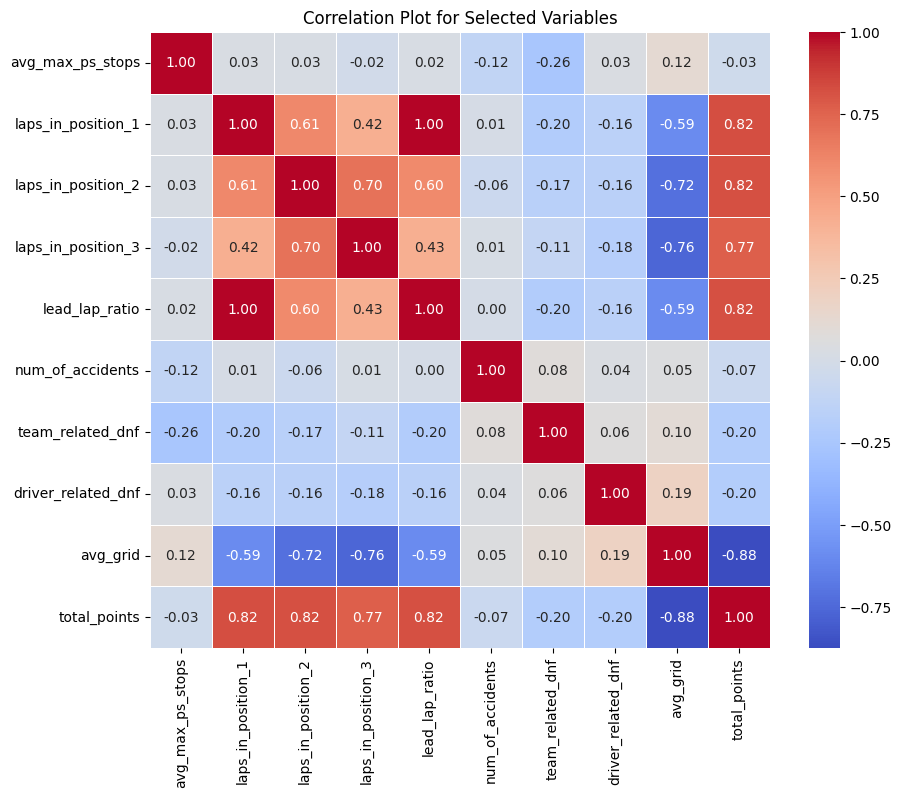

In [487]:
df_analysis = df.drop(columns=['year', 'driverId'])
correlation_matrix = df_analysis.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Plot for Selected Variables')
plt.show()

# PCA

In [488]:
df_analysis = df.drop(columns=['year', 'driverId', 'total_points'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_analysis)

pca = PCA(n_components=len(df_analysis.columns))
principal_components = pca.fit_transform(df_scaled)

# pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(df_analysis.columns))])
# pc_df

components_df = pd.DataFrame(pca.components_, columns=[f'PC{i+1}' for i in range(len(df_analysis.columns))], index=df_analysis.columns)
components_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
avg_max_ps_stops,0.000846,0.448626,0.444732,0.400287,0.449549,-0.020710,-0.132610,-0.142832,-0.447445
laps_in_position_1,0.680046,0.072642,-0.022699,-0.148995,0.072190,-0.352405,-0.591480,0.043257,0.168597
laps_in_position_2,0.083412,0.295709,-0.090266,-0.201739,0.289896,0.690108,-0.107839,0.510793,0.154676
laps_in_position_3,0.000885,-0.046447,0.145779,0.130940,-0.046316,-0.445633,0.235941,0.826011,-0.144045
lead_lap_ratio,0.285341,-0.420572,0.205350,0.498814,-0.421361,0.431099,-0.210394,0.097871,-0.182978
num_of_accidents,0.655561,0.080420,0.046556,0.024045,0.076708,0.081960,0.721646,-0.155580,0.058720
team_related_dnf,-0.088484,-0.078792,0.849504,-0.319874,-0.092087,0.034848,0.013589,-0.025938,0.389145
driver_related_dnf,-0.107553,0.123429,-0.079075,0.638759,0.117457,-0.082194,0.006652,0.008039,0.733669
avg_grid,0.001153,-0.706446,0.007207,-0.001119,0.707675,0.003215,0.001365,0.001566,0.007804


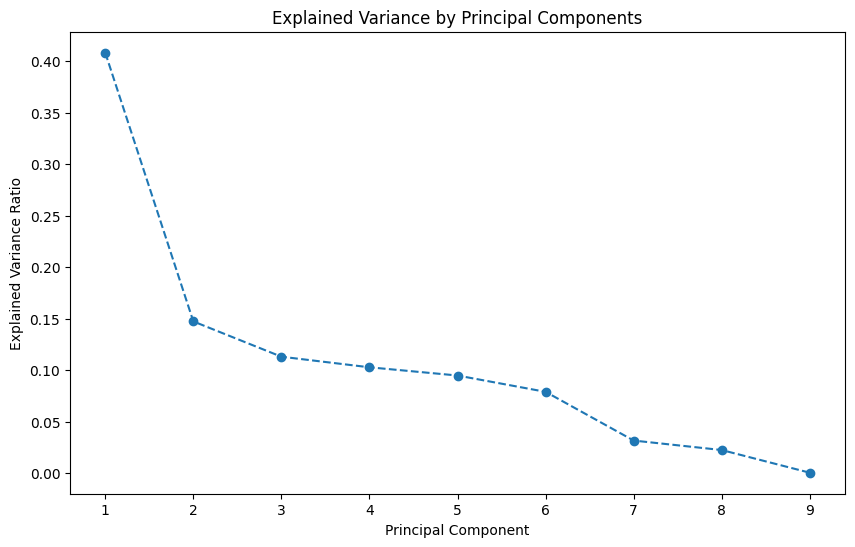

In [489]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(df_analysis.columns) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

In [490]:
def biplot(pca_scores, components, labels=None, scale=10):
    plt.figure(figsize=(10, 7))
    
    # Plot the PCA scores (the observations in the space of the first two PCs)
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], color='blue', alpha=0.5)
    
    # Plot feature vectors (loadings) with scaling for better visibility
    for i, (component, label) in enumerate(zip(components, labels)):
        plt.arrow(0, 0, component[0] * scale, component[1] * scale, color='red', alpha=0.7, head_width=0.1)
        plt.text(component[0] * scale * 1.15, component[1] * scale * 1.15, label, color='black', ha='center', va='center')

    # Formatting the plot
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Biplot of the First 2 Principal Components')
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.grid(True)
    plt.savefig("plot.pdf", format="pdf", bbox_inches="tight")
    plt.show()

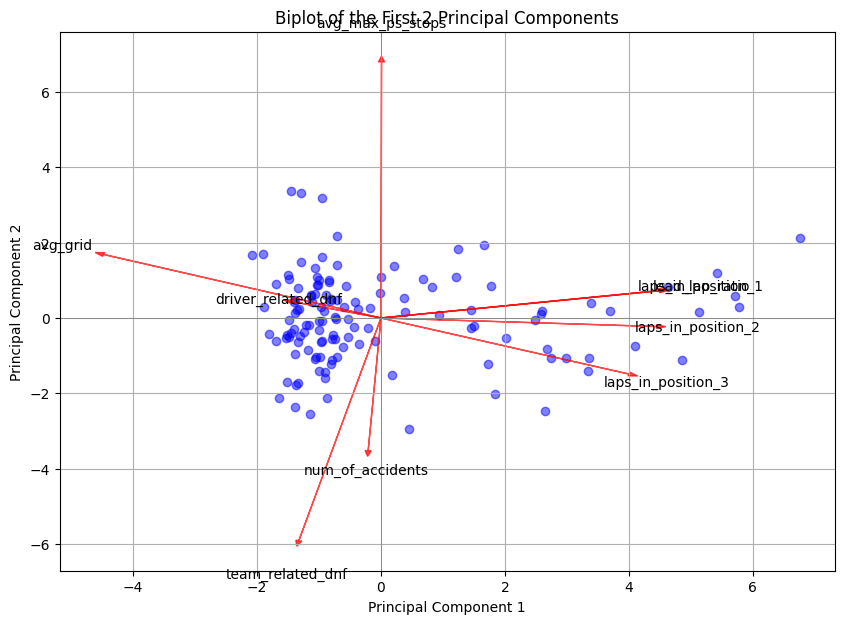

In [491]:
pca2 = PCA(n_components=2)
pca_scores2 = pca2.fit_transform(df_scaled)

biplot(pca_scores2[:, :2], pca2.components_.T, labels=df_analysis.columns)

# ML Models

# PC Regression

In [492]:
Y = df['total_points']
X_pca_with_const = sm.add_constant(principal_components)

In [493]:
model = sm.OLS(Y, X_pca_with_const)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_points   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     331.6
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.31e-79
Time:                        15:52:23   Log-Likelihood:                -580.64
No. Observations:                 128   AIC:                             1181.
Df Residuals:                     118   BIC:                             1210.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.5625      2.079     47.403      0.000      94.445     102.680
x1            58.5405      1.085     53.972      0.000      56.393      60.688
x2            -4.5867      1.805     -2.540      0.012      -8.162      -1.011
x3            -1.5160      2.061     -0.736      0.463      -5.597       2.565
x4            11.4033      2.162      5.276      0.000       7.123      15.684
x5             0.2560      2.251      0.114      0.910      -4.201       4.713
x6            -0.4815      2.466     -0.195      0.846      -5.365       4.402
x7           -10.6439      3.894     -2.733      0.007     -18.356      -2.932
x8            -7.2257      4.624     -1.563      0.121     -16.383       1.932
x9          -170.6485     33.267     -5.130      0.000    -236.526    -104.771
==============================================================================
Omnibus:                        6.949   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                8.825
Skew:                          -0.300   Prob(JB):                       0.0121
Kurtosis:                       4.138   Cond. No.                         30.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Linear Regression

In [494]:
X_with_const = sm.add_constant(df_analysis)

In [ ]:
model = sm.OLS(Y, X_with_const)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_points   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     331.6
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.31e-79
Time:                        15:52:23   Log-Likelihood:                -580.64
No. Observations:                 128   AIC:                             1181.
Df Residuals:                     118   BIC:                             1210.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                166.5991     15.193     10.966      0.000     136.514     196.684
avg_max_ps_stops      -5.1453      5.993     -0.859      0.392     -17.013       6.722
laps_in_position_1     0.9731      0.158      6.172      0.000       0.661       1.285
laps_in_position_2     0.1664      0.031      5.334      0.000       0.105       0.228
laps_in_position_3     0.2787      0.039      7.204      0.000       0.202       0.355
lead_lap_ratio      -803.1732    197.812     -4.060      0.000   -1194.895    -411.452
num_of_accidents      -8.5952      3.054     -2.815      0.006     -14.643      -2.548
team_related_dnf      -3.4251      2.500     -1.370      0.173      -8.375       1.525
driver_related_dnf     0.2015      3.164      0.064      0.949      -6.064       6.467
avg_grid              -9.2824      0.893    -10.391      0.000     -11.051      -7.514
==============================================================================
Omnibus:                        6.949   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                8.825
Skew:                          -0.300   Prob(JB):                       0.0121
Kurtosis:                       4.138   Cond. No.                     1.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""